In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score

# Ensures inline display of plots (for Jupyter).
%matplotlib inline 


In [2]:
# Loading the California housing dataset into a DataFrame.
data = fetch_california_housing(as_frame=True)
df = data.frame

# Basic EDA to understand structure, stats, and check for missing values.
print("Dataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Summary Statistics:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000 

## Exploratory Data Analysis

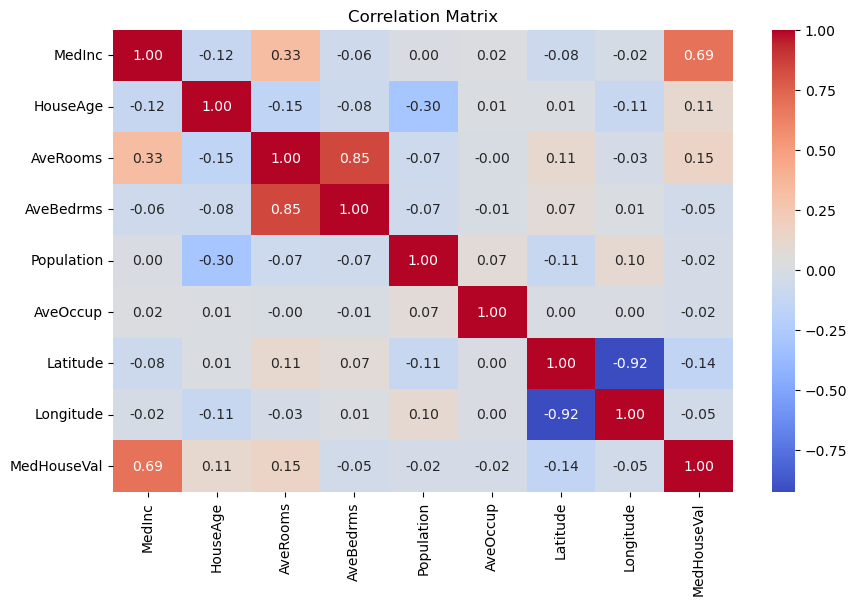

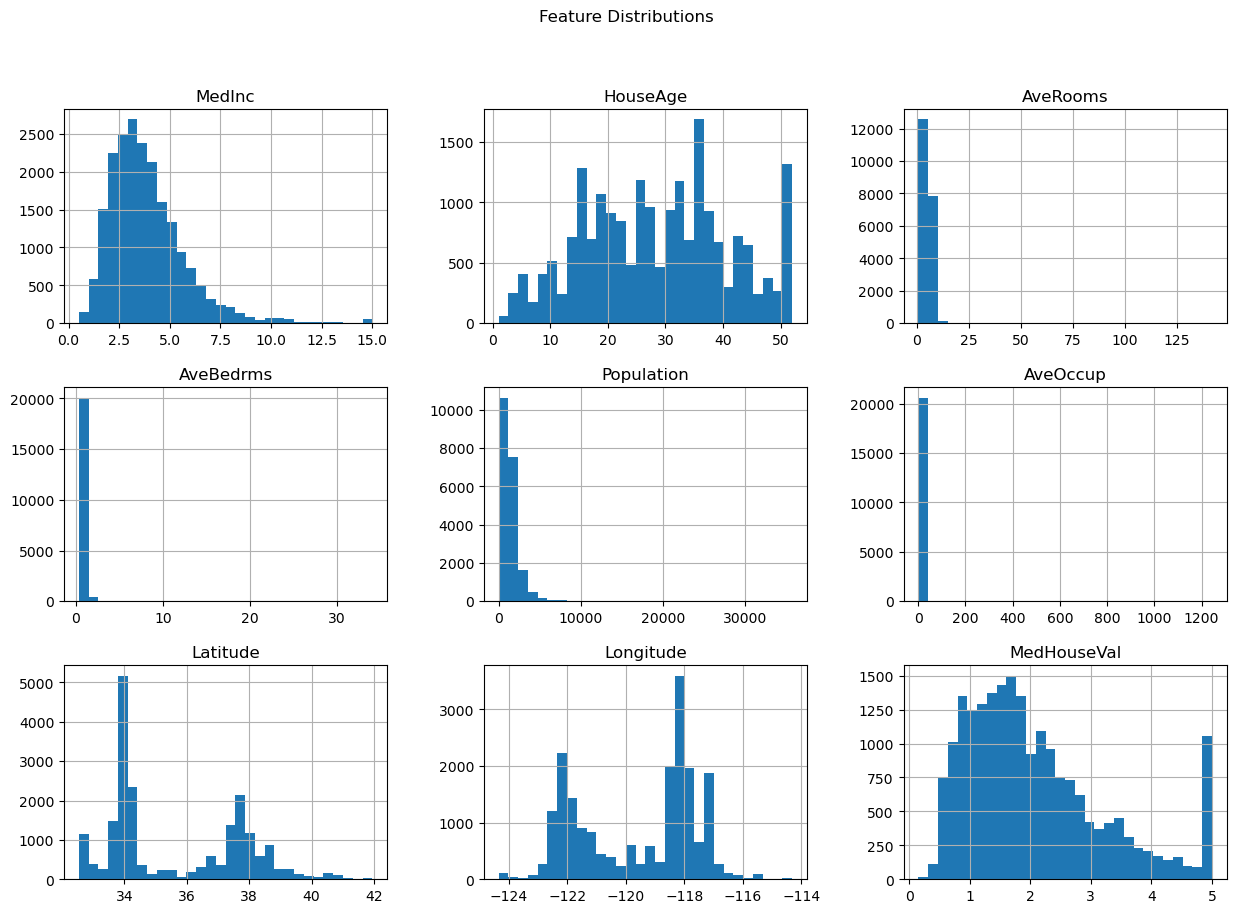

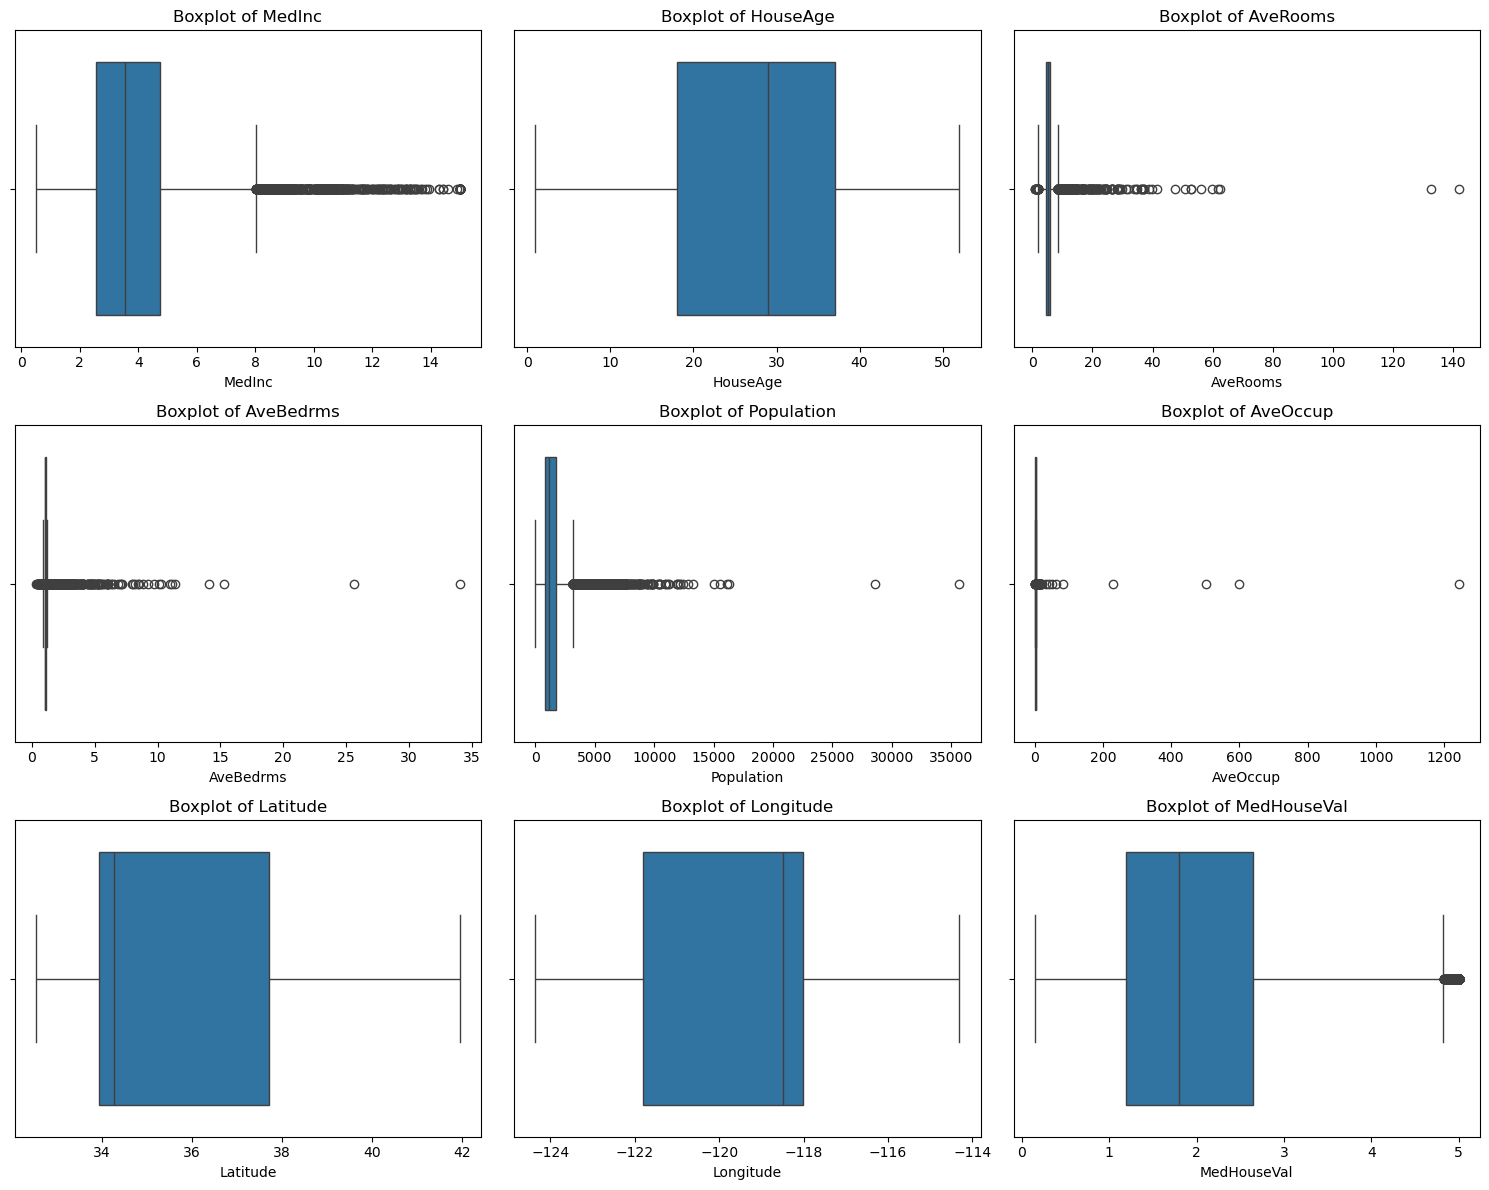

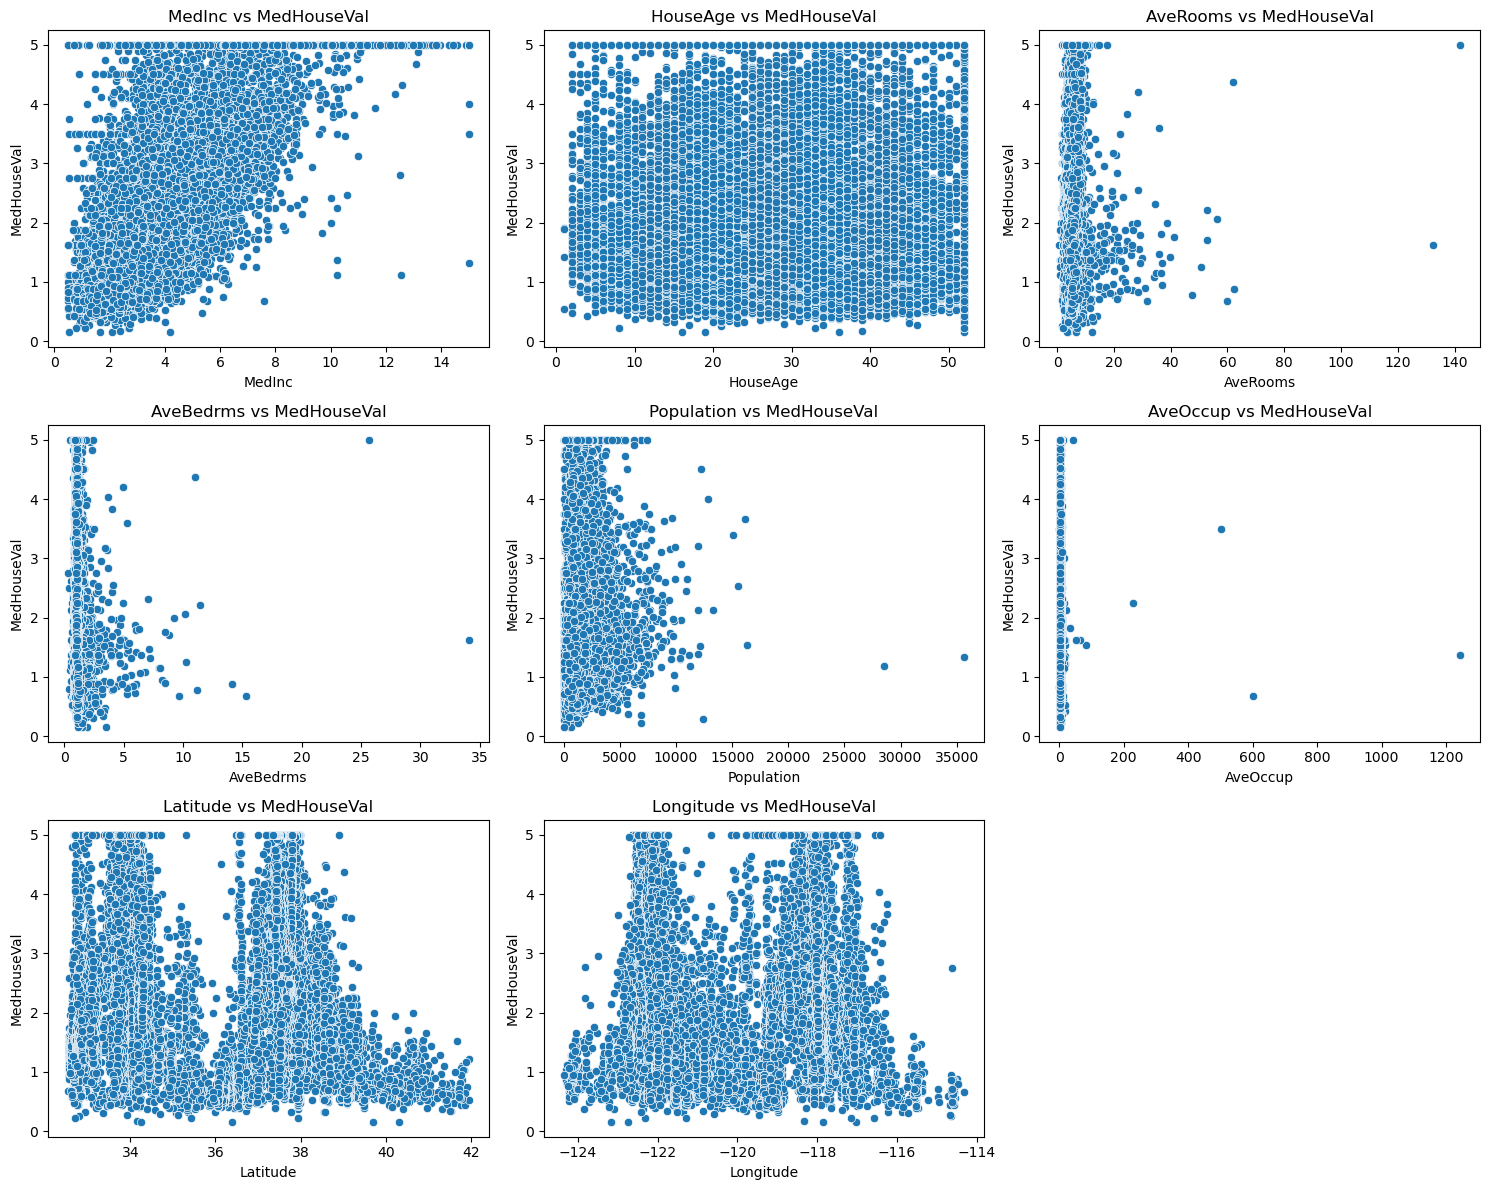

In [3]:
# Visual EDA to explore relationships and spot patterns in the data.

# Correlation heatmap to see how features relate to each other.
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Histograms to visualize the distribution of each feature.
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

# Boxplots - 3 plots per row for cleaner visual alignment.
num_cols = df.shape[1]
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(df.columns):
    r, c = divmod(i, cols_per_row)
    sns.boxplot(x=df[col], ax=axes[r][c])
    axes[r][c].set_title(f'Boxplot of {col}')

# Hide empty subplots if any
for j in range(i + 1, rows * cols_per_row):
    r, c = divmod(j, cols_per_row)
    fig.delaxes(axes[r][c])

plt.tight_layout()
plt.show()

# Scatter plots - 3 plots per row to examine how each feature relates to the target variable.
features = df.columns[:-1]
cols_per_row = 3
rows = (len(features) + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5, rows * 4))

for i, col in enumerate(features):
    r, c = divmod(i, cols_per_row)
    sns.scatterplot(x=df[col], y=df['MedHouseVal'], ax=axes[r][c])
    axes[r][c].set_title(f'{col} vs MedHouseVal')

# Hide empty subplots if any
for j in range(i + 1, rows * cols_per_row):
    r, c = divmod(j, cols_per_row)
    fig.delaxes(axes[r][c])

plt.tight_layout()
plt.show()


## Data Pre-processing

In [4]:
# Data Preprocessing Steps

# Check for missing values (none expected in this dataset).
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Remove outliers using IQR method (optional cleanup for extreme values).
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[col] >= lower) & (df[col] <= upper)]

for col in df.columns:
    df = remove_outliers_iqr(df, col)

# Log transform highly skewed features. Helps to normalize distributions and reduce the effect of extreme values.
skewed = df.skew().sort_values(ascending=False)
skewed_features = skewed[abs(skewed) > 0.75].index
df[skewed_features] = np.log1p(df[skewed_features])

# Checking post-transformation structure and stats.
print(df.info())
print(df.describe())

# Feature scaling and train-test split. Separating target and predictors.
X = df.drop('MedHouseVal', axis=1)
y = df['MedHouseVal']

# Splitting the data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features for better model performance.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<class 'pandas.core.frame.DataFrame'>
Index: 16232 entries, 3 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       16232 non-null  float64
 1   HouseAge     16232 non-null  float64
 2   AveRooms     16232 non-null  float64
 3   AveBedrms    16232 non-null  float64
 4   Population   16232 non-null  float64
 5   AveOccup     16232 non-null  float64
 6   Latitude     16232 non-null  float64
 7   Longitude    16232 non-null  float64
 8   MedHouseVal  16232 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  16232.000000  16232.000000  16232.000000  16232.000000  16232.000000   
mean       3.648737     29.413011      5.150816      1.046886   1278.902292   
std        1.435056     12.187341      1.036654      0.065829    633.567975   
min        0.536000      1.000000      2.133929      0.869822      5.00000

## Modelling

In [5]:
# Training a simple linear regression model on the scaled features.
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Tuned AdaBoost Regression with Decision Tree as base estimator. Boosting with max_depth of 4 trees and higher n_estimators & lower learning rate.
base_est = DecisionTreeRegressor(max_depth=4)
ada = AdaBoostRegressor(estimator=base_est, n_estimators=200, learning_rate=0.1, random_state=42)
ada.fit(X_train_scaled, y_train)
y_pred_ada = ada.predict(X_test_scaled)

# Evaluation Function (regression metrics only).
def regression_report(y_true, y_pred, model_name="Model"):
    print(f"\n{model_name} Evaluation Metrics:")
    print("-" * 40)
    print("R² Score           :", r2_score(y_true, y_pred))
    print("RMSE               :", mean_squared_error(y_true, y_pred, squared=False))
    print("MAE                :", mean_absolute_error(y_true, y_pred))
    print("Median AbsoluteErr :", median_absolute_error(y_true, y_pred))
    print("Explained Variance :", explained_variance_score(y_true, y_pred))

# Model Reports
regression_report(y_test, y_pred_lr, "Linear Regression")
regression_report(y_test, y_pred_ada, "AdaBoost Regression (Tuned)")


Linear Regression Evaluation Metrics:
----------------------------------------
R² Score           : 0.6241786277437548
RMSE               : 0.560959955138244
MAE                : 0.42456784563319555
Median AbsoluteErr : 0.33918160968878386
Explained Variance : 0.624186059000722

AdaBoost Regression (Tuned) Evaluation Metrics:
----------------------------------------
R² Score           : 0.569330361990662
RMSE               : 0.6005003299185167
MAE                : 0.49007563403376003
Median AbsoluteErr : 0.44610010427528457
Explained Variance : 0.6275514940282472


C:\Barzini\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Barzini\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Combine and display first 10 actual and predicted values from both models
comparison_df = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Linear Regression Prediction": y_pred_lr[:10],
    "AdaBoost Prediction": y_pred_ada[:10]
})

print("\nFirst 10 Predictions vs Actual Values (Both Models):")
print(comparison_df)

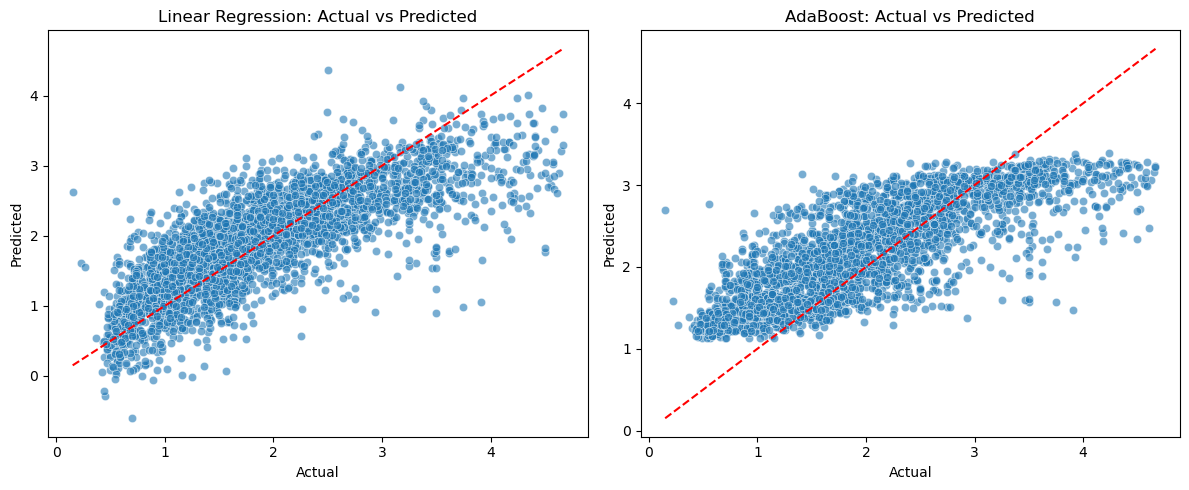

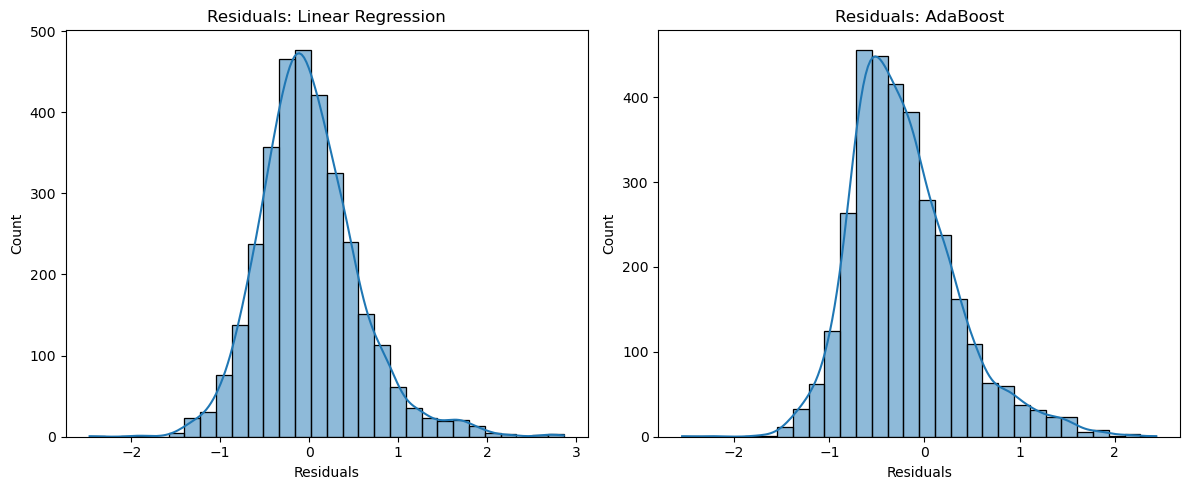

In [6]:
# Actual vs Predicted Scatter Plots. Helps visually assess how close predictions are to actual values.
plt.figure(figsize=(12, 5))

# Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")

# AdaBoost Regression
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_ada, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("AdaBoost: Actual vs Predicted")

plt.tight_layout()
plt.show()

# 11. Residual Plots Side-by-Side. This helps visualize model error trends
residuals_lr = y_test - y_pred_lr
residuals_ada = y_test - y_pred_ada

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(residuals_lr, bins=30, kde=True)
plt.title("Residuals: Linear Regression")
plt.xlabel("Residuals")

plt.subplot(1, 2, 2)
sns.histplot(residuals_ada, bins=30, kde=True)
plt.title("Residuals: AdaBoost")
plt.xlabel("Residuals")

plt.tight_layout()
plt.show()
